<a href="https://colab.research.google.com/github/ihatethinkingname/dl_practice/blob/main/sasrec_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import copy
import math


In [3]:
# Transformer practice part

class EnD(nn.Module):
  def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.src_embed=src_embed
    self.tgt_embed=tgt_embed
    self.generator=generator

  def forward(self,src,tgt,src_mask,tgt_mask):
    return self.decoder(self.encoder(src,src_mask),src_mask,tgt,tgt_mask)

  def encode(self,src,src_mask):
    return self.encoder(self.src_embed(src),src_mask)

  def decode(self,memory,src_mask,tgt,tgt_mask):
    return self.decoder(memory,src_mask,self.tgt_embed(tgt),tgt_mask)

class Embeddings(nn.Module):
  def __init__(self,vocab_size,d_model):
    super().__init__()
    self.lut=nn.Embedding(vocab_size,d_model,padding_idx=0)
    self.d_model=d_model
  @property
  def weight(self):
    return self.lut.weight
  def forward(self,x):
    return self.lut(x) * math.sqrt(self.d_model)

class PositionalEmbedding(nn.Module):
  def __init__(self,d_model,max_len=5000,dropout_rate=0.1):
    super().__init__()
    self.pos_embedding=nn.Embedding(max_len,d_model,padding_idx=0)
    self.dropout=nn.Dropout(dropout_rate)
  @property
  def weight(self):
    return self.pos_embedding.weight
  def forward(self,x,zero_padding=True):
    batch_size=x.shape[0]
    seq_len=x.shape[1]
    device=x.device
    pos_idx=torch.arange(0,seq_len,device=device).unsqueeze(0).expand(batch_size,seq_len)
    if zero_padding:
      pad_mask=x.abs().sum(dim=-1)!=0
      pos_idx=pos_idx*pad_mask.long()
    x = x + self.pos_embedding(pos_idx)
    return self.dropout(x)

class Generator(nn.Module):
  def __init__(self,d_model,vocab_size):
    super().__init__()
    self.proj=nn.Linear(d_model,vocab_size)

  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1)


class EnDcoder(nn.Module):
  def __init__(self,layer,N):
    super().__init__()
    self.layers=clone(layer,N)
    self.norm=nn.LayerNorm(layer.d_model)

  def forward(self,x,src_mask,tgt=None,tgt_mask=None):
    for layer in self.layers:
      x=layer(x,src_mask,tgt,tgt_mask)
    return self.norm(x)

def clone(layer,N):
  return nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

class EnDcoderLayer(nn.Module):
  def __init__(self,self_attn,ffn,d_model,dropout_rate,src_attn=None):
    super().__init__()
    self.self_attn=self_attn
    self.ffn=ffn
    self.connector=clone(SublayerConnection(d_model,dropout_rate),2)
    self.d_model=d_model
    if src_attn is not None:
      self.src_attn=src_attn
      self.connector.append(SublayerConnection(d_model,dropout_rate))

  def forward(self,x,src_mask,tgt=None,tgt_mask=None):
    if isEncoder(tgt,tgt_mask):
      x=self.connector[0](x,lambda x: self.self_attn(x,x,x,src_mask))
    else:
      m=x         # m is memoery
      x=tgt        # We keep using x as the thing go through the network
      x=self.connector[0](x,lambda x: self.self_attn(x,x,x,tgt_mask))
      x=self.connector[1](x,lambda x: self.src_attn(x,m,m,src_mask))
    return self.connector[-1](x,self.ffn)

def isEncoder(tgt,tgt_mask):
    # Encoder model
    if tgt is None and tgt_mask is None:
      return True
    # Decoder model
    elif tgt is not None and tgt_mask is not None:
      return False
    # Wrong input
    else:
      raise ValueError("Encoder instance input error: "\
               "tgt and tgt_mask should be both None or both not None.")

class SublayerConnection(nn.Module):
  def __init__(self,d_model,dropout_rate):
    super().__init__()
    self.norm=nn.LayerNorm(d_model)
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,x,sublayer):
    return x+self.dropout(sublayer(self.norm(x)))

def attention(q,k,v,mask=None,dropout=None):
  d_k=q.shape[-1]
  scores=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
  p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,v),p_attn

class MultiHeadedAttention(nn.Module):
  def __init__(self,n_head,d_model,dropout_rate=0.1):
    super().__init__()
    assert d_model%n_head==0
    self.d_head=d_model//n_head
    self.n_head=n_head
    self.linears=clone(nn.Linear(d_model,d_model),4)
    self.p_attn=None
    self.dropout=nn.Dropout(p=dropout_rate)

  def forward(self,query,key,value,mask=None):
    if mask is not None:
      if mask.dim() == 3:
        mask = mask.unsqueeze(1)  # (batch,1,seq_len,seq_len)
        print("org mask dim is 3")
      elif mask.dim() == 4 and mask.size(1) != 1:
        print("fine")
        raise ValueError(f"mask shape {mask.shape} 不符合要求")
    batch_size,seq_len,d_model=query.shape
    assert d_model==self.n_head*self.d_head
    q,k,v=[l(x).view(batch_size,seq_len,self.n_head,self.d_head).transpose(1,2)
        for l,x in zip(self.linears,(query,key,value))]
    x,self.p_attn=attention(q,k,v,mask=mask,dropout=self.dropout)
    x=x.transpose(1,2).contiguous().view(batch_size,seq_len,self.n_head*self.d_head)

    return self.linears[-1](x)

class FFN(nn.Module):
  def __init__(self,d_model,d_ff,dropout_rate=0.1):
    super().__init__()
    self.L1=nn.Linear(d_model,d_ff)
    self.dropout=nn.Dropout(0.1)
    self.L2=nn.Linear(d_ff,d_model)

  def forward(self,x):
    return self.L2(self.dropout(F.relu(self.L1(x))))

def causal_mask(seq_len,device):
  # causal_mask=~torch.tril(torch.ones((seq_len,seq_len),dtype=torch.float,device=self.device))
  i=torch.arange(seq_len,device=device)
  return (i[:,None])>=(i[None,:])

def make_model(src_vocab,tgt_vocab,d_model=512,n_sublayer=6,d_ff=2048,n_head=8,dropout_rate=0.1):
  c=copy.deepcopy

  src_embed=Embeddings(src_vocab,d_model)
  tgt_embed=Embeddings(tgt_vocab,d_model)
  generator=Generator(d_model,tgt_vocab)
  pos_embed=PositionalEmbedding(d_model)

  attn=MultiHeadedAttention(n_head,d_model,dropout_rate)
  ffn=FFN(d_model,d_ff,dropout_rate)
  encoder=EnDcoder(EnDcoderLayer(c(attn),c(ffn),d_model,dropout_rate),n_sublayer)
  decoder=EnDcoder(EnDcoderLayer(c(attn),c(ffn),d_model,dropout_rate,c(attn)),n_sublayer)

  model=EnD(encoder,decoder,nn.Sequential(c(src_embed),c(pos_embed)),
            nn.Sequential(c(tgt_embed),c(pos_embed)),generator)

  for p in model.parameters():
    if p.dim()>1:
      nn.init.xavier_uniform_(p)

  return model


In [4]:
# SASRec practice part

class SASRec(nn.Module):
  def __init__(self,n_user,n_item,args):
    super().__init__()
    self.n_user=n_user
    self.n_item=n_item
    self.device=args.device
    d_model=args.d_model

    self.item_emb=Embeddings(n_item+1,d_model)
    self.pos_emb=PositionalEmbedding(d_model,args.max_len,args.dropout_rate)

    self.self_attn=MultiHeadedAttention(args.n_head,d_model,args.dropout_rate)
    self.ffn=FFN(d_model,args.d_ff,args.dropout_rate)
    self.encoder=EnDcoder(EnDcoderLayer(self.self_attn,self.ffn,d_model,args.dropout_rate),args.n_sublayer)


  def log2feat(self,log_seq):  # Is log_seq a tensor?
    if not torch.is_tensor(log_seq):
      log_seq = torch.as_tensor(log_seq)
    log_seq = log_seq.to(self.device, dtype=torch.long)
    pad_mask=(log_seq!=0).unsqueeze(1).unsqueeze(2)

    log_seq=self.pos_emb(self.item_emb(log_seq))

    seq_len=log_seq.shape[1]
    a_causal_mask=causal_mask(seq_len,self.device).unsqueeze(0).unsqueeze(1)
    combined_mask=pad_mask & a_causal_mask
    feat_seq=self.encoder(log_seq,combined_mask)

    return feat_seq

  def forward(self,log_seq,pos_seq,neg_seq):  # Are pos_seq and neg_seq float?
    feat_seq=self.log2feat(log_seq)

    if not torch.is_tensor(pos_seq):
        pos_seq = torch.as_tensor(pos_seq)
    if not torch.is_tensor(neg_seq):
        neg_seq = torch.as_tensor(neg_seq)
    pos_seq_embed=self.item_emb(pos_seq.to(dtype=torch.long, device=self.device))
    neg_seq_embed=self.item_emb(neg_seq.to(dtype=torch.long, device=self.device))

    pos_logits=(feat_seq*pos_seq_embed).sum(dim=-1)
    neg_logits=(feat_seq*neg_seq_embed).sum(dim=-1)

    return pos_logits,neg_logits

  def predict(self,log_seq,item_indices):
    feat_seq=self.log2feat(log_seq)[:,-1,:]

    if not torch.is_tensor(item_indices):
      item_indices = torch.as_tensor(item_indices)
    item_indices=item_indices.to(dtype=torch.long,device=self.device)

    item_embed=self.item_emb(item_indices)

    logits=item_embed.matmul(feat_seq.unsqueeze(-1)).squeeze(-1)

    return logits

  def xavier_normal_init_parameters(self):
    for name, param in self.named_parameters():
      if param.dim()>1:
        nn.init.xavier_normal_(param)
    self.item_emb.weight.data[0,:]=0
    self.pos_emb.weight.data[0,:]=0

In [5]:
# Use comet for experiment management

!pip install comet_ml > /dev/null 2>&1
import comet_ml
from google.colab import userdata
COMET_API_KEY=userdata.get('comet_api_key')

# Create a Comet experiment to track our training run
def create_experiment(args):
  # End any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # Initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="sasrec_practice")

  # Log our hyperparameters, defined above, to the experiment
  for param, value in vars(args).items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

In [6]:
import os
import time
from collections import defaultdict
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
!pip install lion-pytorch > /dev/null 2>&1
from lion_pytorch import Lion

def download_from_github(file_url, local_filename=None):
    if local_filename is None:
        local_filename = file_url.split('/')[-1]

    if os.path.exists(local_filename):
        print(f"文件已存在：{local_filename}，跳过下载")
    else:
        print(f"开始下载 {local_filename} ...")
        !wget -q {file_url}
        print(f"下载完成：{local_filename}")

def read_file(filepath='ml-1m.txt'):
    user_hist = defaultdict(list)
    with open(filepath, 'r') as f:
        for line in f:
            user, item = line.strip().split()
            user, item = int(user), int(item)
            user_hist[user].append(item)
    return user_hist

# Actually, these three aren't needed, since the data has been processed
def create_item_mapping(user_hist):
    all_items = set()
    for items in user_hist.values():
        all_items.update(items)
    item2idx = {item: idx + 1 for idx, item in enumerate(all_items)}  # 0 用于 PAD
    idx2item = {idx: item for item, idx in item2idx.items()}
    return item2idx, idx2item

def create_user_mapping(user_hist):
    all_users = sorted(user_hist.keys())
    user2idx = {u: idx + 1 for idx, u in enumerate(all_users)}  # 1-based, 0 for padding if needed
    idx2user = {idx: u for u, idx in user2idx.items()}
    return user2idx, idx2user

def make_consecutive_user_hist(user_hist, user2idx, item2idx):
    new_user_hist = defaultdict(list)
    for user, items in user_hist.items():
        if user not in user2idx:  # Theoretically won't happen, just in case user_hist was changed
            continue
        new_u = user2idx[user]
        new_items = [item2idx[i] for i in items if i in item2idx]
        new_user_hist[new_u].extend(new_items)
    return new_user_hist


def data_partition(user_hist):
  user_train = {}
  user_valid = {}
  user_test = {}
  for user in user_hist:
    n_feedback=len(user_hist[user])
    if n_feedback<4:     # Change, n_feedback==3 would be discraded in SASRecDataset
      user_train[user]=user_hist[user]
      user_valid[user]=[]
      user_test[user]=[]
    else:
      user_train[user]=user_hist[user][:-2]
      user_valid[user]=[user_hist[user][-2]]
      user_test[user]=[user_hist[user][-1]]
  return user_train,user_valid,user_test

def random_seq(l,r,s):
  rand=np.random.randint(l,r)
  while rand in s:
    rand=np.random.randint(l,r)
  return rand

class SASRecDataset(Dataset):
  def __init__(self,user_train,n_user,n_item,max_len):
    self.user_train=user_train
    self.n_user=n_user
    self.n_item=n_item
    self.max_len=max_len
    self.users=[u for u in range(1,n_user+1) if len(user_train[u])>1]

  def __len__(self):
    return len(self.users)

  def __getitem__(self,idx):
    uid=self.users[idx]
    seq, pos, neg=(np.zeros(self.max_len,dtype=np.int32) for _ in range(3))

    nxt=self.user_train[uid][-1]
    idx=self.max_len-1
    ts=set(self.user_train[uid])

    for i in reversed(self.user_train[uid][:-1]):
      seq[idx]=i
      pos[idx]=nxt
      neg[idx]=random_seq(1,self.n_item+1,ts) # Change, don't need "if nxt != 0"
      nxt=i
      idx-=1
      if idx==-1:
        break

    uid, seq, pos, neg=(torch.tensor(x, dtype=torch.long) for x in (uid, seq, pos, neg))

    return uid, seq, pos, neg

class BPRLoss(nn.Module):
  def forward(self,pos_logits,neg_logits):
    return -torch.mean(F.logsigmoid(pos_logits-neg_logits))

def share_eval(model,dataset,args,evaluate_test,criterion):
  [train, valid, test] = copy.deepcopy(dataset)

  # Maybe better way
  all_users = set(user_train.keys()) | set(user_valid.keys()) | set(user_test.keys())
  usernum = max(all_users)   # 如果用户 id 从 1 开始连续
  # usernum = len(all_users) # 如果你把用户重新映射过

  # 2. 物品 id
  all_items = set()
  for dataset in (user_train, user_valid, user_test):
      for items in dataset.values():
          all_items.update(items)
  itemnum = max(all_items)


  NDCG = 0.0
  valid_user = 0.0
  HT = 0.0
  total_loss = 0.0

  if usernum>10000:
    users = random.sample(range(1, usernum + 1), 10000)
  else:
    users = range(1, usernum + 1)

  for u in users:
    if len(train[u]) < 1 or len(valid[u]) < 1: continue # Not necessary

    seq = np.zeros([args.max_len], dtype=np.int32)
    idx = args.max_len - 1
    if evaluate_test:
      seq[idx] = valid[u][0]
      idx -= 1
    for i in reversed(train[u]):
        seq[idx] = i
        idx -= 1
        if idx == -1: break

    rated = set(train[u])
    rated.add(0)
    item_idx = [valid[u][0]]
    for _ in range(100):
        t = np.random.randint(1, itemnum + 1)
        while t in rated: t = np.random.randint(1, itemnum + 1)
        item_idx.append(t)

    seq_t = torch.tensor([seq], dtype=torch.long, device=args.device)
    item_t = torch.tensor(item_idx, dtype=torch.long, device=args.device)

    # predictions = -model.predict(seq_t, item_t)
    # predictions = predictions[0]

    # rank = predictions.argsort().argsort()[0].item()

    predictions = model.predict(seq_t, item_t)
    predictions = predictions[0]

    rank = predictions.argsort(descending=True).argsort()[0].item()

    valid_user += 1

    if rank < 10:
        NDCG += 1 / np.log2(rank + 2)
        HT += 1

    pos_logits = predictions[0:1]  # 第0个是正样本
    neg_logits = predictions[1:] # 剩下的是负样本
    # 转 tensor
    pos_logits = torch.tensor(pos_logits, device=args.device)
    neg_logits = torch.tensor(neg_logits, device=args.device)
    loss = criterion(pos_logits, neg_logits)
    total_loss += loss.item()

    if valid_user % 100 == 0:
        print('.', end="")
        sys.stdout.flush()

  return NDCG / valid_user, HT / valid_user, total_loss / valid_user

def evaluate_valid(model,dataset,args):
  return share_eval(model,dataset,args,evaluate_test=False,criterion=bpr_criterion)

def evaluate(model,dataset,args):
  return share_eval(model,dataset,args,evaluate_test=True,criterion=bpr_criterion)

class PeriodicPlotter:
  def __init__(self, sec, xlabel="", ylabel="", scale=None):
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
          plt.plot(data)
      elif self.scale == "semilogx":
          plt.semilogx(data)
      elif self.scale == "semilogy":
          plt.semilogy(data)
      elif self.scale == "loglog":
          plt.loglog(data)
      else:
          raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel)
      plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()


In [7]:
import argparse

args=dict(
    d_model=32,
    n_head=2,
    d_ff=4*32,
    n_sublayer=4,
    dropout_rate=0.0,

    device='cuda:0',
    # device='cpu',
    inference_only=False,
    n_epoch=1000,
    eval_freq=100,
    batch_size=512,
    max_len=200,
    # l2_emb=1e-5,
    l2_emb=0.0,
    lr=1e-4,
    n_neg_sample=1,   # Use 1 negative sample first
    num_workers=8,

    top_k=10
)
args = argparse.Namespace(**args)

In [8]:
# Import data
file_url = "https://raw.githubusercontent.com/pmixer/SASRec.pytorch/bdb6b77da98b9d6c395283d8b4e1a8bd7cb91efa/python/data/ml-1m.txt"
download_from_github(file_url)
user_hist=read_file()

# Data processing and preparing part

# Not actually needed. This dataset has processed in "User Item" form with continuous int id
user2idx, idx2user = create_user_mapping(user_hist)
item2idx, idx2item = create_item_mapping(user_hist)
user_hist = make_consecutive_user_hist(user_hist, user2idx, item2idx)
n_user = len(user2idx)
n_item = len(item2idx)

user_train,user_valid,user_test = data_partition(user_hist)
dataset = SASRecDataset(user_train, n_user, n_item, args.max_len)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

cc = 0.0
for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))

print("n_item:", n_item)
print("max item id in train:", max([max(seq) for seq in user_train.values()]))
print("min item id in train:", min([min(seq) for seq in user_train.values()]))

model=SASRec(n_user,n_item,args).to(args.device)
model.xavier_normal_init_parameters()

if args.inference_only:
  model.eval()
  t_test=evaluate(model,dataset,args)
  print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

model.train()


# Train part
bpr_criterion=BPRLoss()
lion_optimizer=Lion(model.parameters(),lr=args.lr,betas=(0.9,0.99),weight_decay=0.0)

best_val_ndcg, best_val_hr=0.0, 0.0

history=defaultdict(list)
# plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
# plt.ion()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

experiment=create_experiment(args)
for epoch in range(args.n_epoch):
  if args.inference_only: break
  step_loss=[]
  total_loss=0.0
  t0=time.time()
  for idx,batch in enumerate(tqdm(dataloader)):
    lion_optimizer.zero_grad()
    u,seq,pos,neg=(i.to(args.device) for i in batch)
    pos_logits,neg_logits=model(seq,pos,neg)
    mask=(pos!=0)
    loss=bpr_criterion(pos_logits[mask],neg_logits[mask])
    emb=model.item_emb.weight
    loss=loss+args.l2_emb*torch.sum(emb**2)  # Change, use sum of squares
    loss.backward()
    lion_optimizer.step()
    step_loss.append(loss.item())
    total_loss += loss.item()
    global_step=epoch*len(dataloader)+idx
    experiment.log_metric("train_loss",loss.item(),step=global_step)

  # Evaluate part
  if epoch%args.eval_freq==0:
    model.eval()
    t1=time.time()-t0
    train_loss=total_loss/len(dataloader)
    t_valid=evaluate_valid(model,data_partition(user_hist),args)
    print('epoch:%d, time: %f(s), train_loss: %.4f, val_loss: %.4f \n \
        valid (NDCG@10: %.4f, HR@10: %.4f)'
        % (epoch, t1, train_loss, t_valid[2], t_valid[0], t_valid[1]))

  experiment.log_metric("val_loss", t_valid[2], step=epoch)
  experiment.log_metric("val_ndcg@10", t_valid[0], step=epoch)
  experiment.log_metric("val_hr@10", t_valid[1], step=epoch)

  history["train_loss_epoch"].append(train_loss)
  history["val_loss"].append(t_valid[2])
  history["ndcg"].append(t_valid[0])
  history["hr"].append(t_valid[1])

  # plotter.plot(history)

  # ax1.clear()
  # ax1.plot(history["train_loss_epoch"], label="Train Loss (epoch)")
  # ax1.plot(history["val_loss"], label="Val Loss")
  # ax1.set_xlabel("Epoch")
  # ax1.set_ylabel("Loss")
  # ax1.legend()
  # ax1.set_title("Loss Curve")

  # ax2.clear()
  # ax2.plot(history["ndcg"], label="NDCG@10")
  # ax2.plot(history["hr"], label="HR@10")
  # ax2.set_xlabel("Epoch")
  # ax2.set_ylabel("Metric")
  # ax2.legend()
  # ax2.set_title("Validation Metrics")

  # plt.pause(0.01)  # 关键：刷新图像
  model.train()
# plt.ioff()
# plt.show()

t_test = evaluate(model, data_partition(user_hist), args)
print('test_loss: %.4f valid (NDCG@10: %.4f, HR@10: %.4f)'
      % (t_test[2], t_test[0], t_test[1]))

experiment.log_metric("test_loss", t_test[2])
experiment.log_metric("test_ndcg@10", t_test[0])
experiment.log_metric("test_hr@10", t_test[1])

# Cleanup stage
torch.save(model.state_dict(), "model.pth")
experiment.log_model("sasrec", "model.pth")
experiment.end()

开始下载 ml-1m.txt ...
下载完成：ml-1m.txt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


average sequence length: 163.50
n_item: 3416
max item id in train: 3416
min item id in train: 1


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/richard-murphy/sasrec-practice/0bf5011aad6e432dbeb8f7233737011f

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Uploading 31 metrics, params and output messages
  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current syste

............................................................epoch:0, time: 5.409155(s), train_loss: 0.7925, val_loss: 0.7597 
         valid (NDCG@10: 0.0562, HR@10: 0.1227)


100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


............................................................epoch:100, time: 5.700232(s), train_loss: 0.1496, val_loss: 0.2122 
         valid (NDCG@10: 0.4785, HR@10: 0.7528)


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


............................................................epoch:200, time: 5.026146(s), train_loss: 0.0965, val_loss: 0.1914 
         valid (NDCG@10: 0.5464, HR@10: 0.8023)


100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


............................................................epoch:300, time: 5.011230(s), train_loss: 0.0828, val_loss: 0.2009 
         valid (NDCG@10: 0.5574, HR@10: 0.8089)


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


............................................................epoch:400, time: 5.149544(s), train_loss: 0.0767, val_loss: 0.2111 
         valid (NDCG@10: 0.5627, HR@10: 0.8131)


100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


............................................................epoch:500, time: 5.510105(s), train_loss: 0.0727, val_loss: 0.2130 
         valid (NDCG@10: 0.5603, HR@10: 0.8086)


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


............................................................epoch:600, time: 4.987254(s), train_loss: 0.0703, val_loss: 0.2195 
         valid (NDCG@10: 0.5602, HR@10: 0.8033)


100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


............................................................epoch:700, time: 5.449047(s), train_loss: 0.0686, val_loss: 0.2228 
         valid (NDCG@10: 0.5595, HR@10: 0.8060)


100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


............................................................epoch:800, time: 5.662603(s), train_loss: 0.0674, val_loss: 0.2240 
         valid (NDCG@10: 0.5565, HR@10: 0.8025)


100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


............................................................epoch:900, time: 4.732928(s), train_loss: 0.0658, val_loss: 0.2313 
         valid (NDCG@10: 0.5596, HR@10: 0.8060)


100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


............................................................test_loss: 0.0501 valid (NDCG@10: 0.8048, HR@10: 0.9513)


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : worried_cephalopod_7198
COMET INFO:     url                   : https://www.comet.com/richard-murphy/sasrec-practice/0bf5011aad6e432dbeb8f7233737011f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_hr@10         : 0.9513245033112583
COMET INFO:     test_loss          : 0.05013943007518976
COMET INFO:     test_ndcg@10       : 0.8047556787412815
COMET INFO:     train_loss [12000] : (0.05844803526997566, 0.8241667151451111)
COMET INFO:     val_hr@10 [1000]   : (0.12268211920529801, 0.8130794701986755)
COMET INFO:     val_loss [1000]    : (0.19142364274884077, 0.7596924987270046)
COMET INFO:     val_ndcg@10 [1000] : (0.05622990669816375, 0

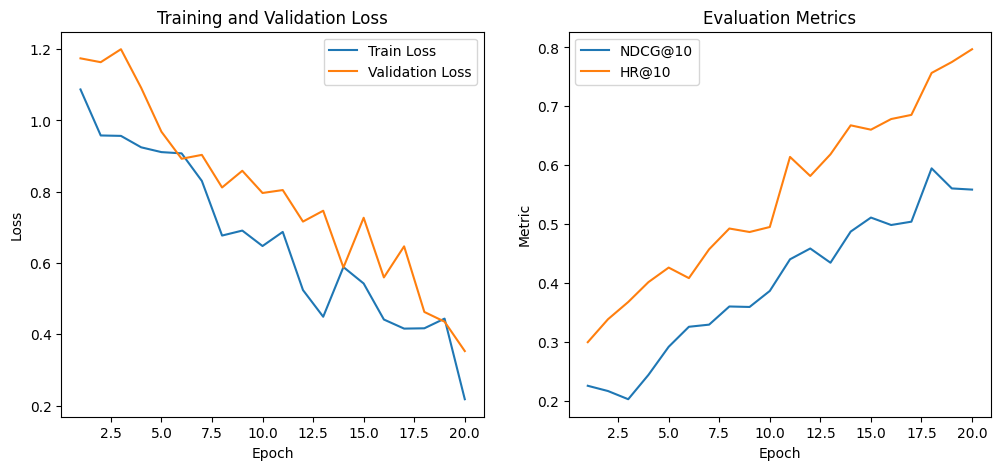

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 生成假数据
epochs = np.arange(1, 21)
train_loss = np.linspace(1.0, 0.3, 20) + np.random.normal(0, 0.05, 20)
val_loss = np.linspace(1.2, 0.4, 20) + np.random.normal(0, 0.05, 20)
ndcg = np.linspace(0.2, 0.6, 20) + np.random.normal(0, 0.02, 20)
hr = np.linspace(0.3, 0.8, 20) + np.random.normal(0, 0.02, 20)

# 绘制子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 损失曲线
ax1.plot(epochs, train_loss, label="Train Loss")
ax1.plot(epochs, val_loss, label="Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()

# 指标曲线
ax2.plot(epochs, ndcg, label="NDCG@10")
ax2.plot(epochs, hr, label="HR@10")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Metric")
ax2.set_title("Evaluation Metrics")
ax2.legend()

plt.show()